# Story Data

In [2]:
# sample Wikipedia articles about famous biographies
URLs = ["https://en.wikipedia.org/wiki/Pieter_Bruegel_the_Elder", "https://en.wikipedia.org/wiki/Vincent_van_Gogh",
        "https://en.wikipedia.org/wiki/Rembrandt", "https://en.wikipedia.org/wiki/Émile_Zola"]
# pick one of articles as a seed entity to be the focus of the generated story
seed_url = URLs[0]
print seed_url

https://en.wikipedia.org/wiki/Pieter_Bruegel_the_Elder


In [3]:
# get WikiData ID
import requests, json
wiki_api_query = "https://www.wikidata.org/w/api.php?action=wbgetentities&sites=enwiki&format=json&titles=%s"

def link_wiki_data(url):
    label = url.strip('/').split('/')[-1]
    response = requests.get(wiki_api_query%label)
    URI = json.loads(response.text)['entities'].keys()[0]
    return label, URI

seed_label, seed_URI = link_wiki_data(seed_url)
print seed_label, seed_URI

Pieter_Bruegel_the_Elder Q43270


In [5]:
# get the corresponding Wiki page
page = requests.get(seed_url).text

# scrape the links
import scrape
# collect the sequence of URLs and the corresponding WikiData IDs
def get_wiki_sequence(scraper):
    '''
    scraper is a function extracting links from a Wiki page
    '''
    URIs = []
    links = scraper(page)
    for link in links:
        _, URI = link_wiki_data(link['url'])
        # skip entities missing from WikiData
        if URI != '-1':
            URIs.append(URI)
#             print(URI)
    return URIs

print("Extracting story sequence")

# get only the links from the article summary
# summary_URIs = get_wiki_sequence(scrape.extract_summary_links)
# print("%d summary URIs extracted"%len(summary_URIs))

# get only the links from the article without the summary
story_URIs = get_wiki_sequence(scrape.extract_story_links)
print("%d story URIs extracted"%len(story_URIs))
# print(story_URIs)

Extracting story sequence


TypeError: expected string or buffer

In [ ]:
# get subgraphs using the SPARQL endpoint http://wikidata.communidata.at
# the following code is adopted from https://github.com/svakulenk0/semantic_coherence
'''
Sample top-k shortest path query:

PREFIX ppf: <java:at.ac.wu.arqext.path.>
PREFIX dbr: <http://dbpedia.org/resource/>
SELECT ?path
WHERE { ?path ppf:topk (?X ?Y 2) . 
VALUES (?X ) { (dbr:Felipe_Massa)(dbr:1952_Winter_Olympics) } .
VALUES (?Y ) { (dbr:Elliot_Richardson) (dbr:Red_Bull) }  }
'''
TOPK_SERVICE = 'http://wikidata.communidata.at/wikidata/query'

TOPK_QUERY_TEMPLATE = '''
                    PREFIX ppf: <java:at.ac.wu.arqext.path.>
                    PREFIX wd: <http://www.wikidata.org/entity/>
                    SELECT * WHERE {
                    ?X ppf:topk ("--source" %s "--target" %s "--k" %d "--maxlength" %d "--timeout" 200)
                    }
                     '''

# define the namespace for all entities
ENTITY_TEMPLATE = "wd:%s"

def get_topk_paths(start_entities, target_entities, k, max_length=5):
    '''
    takes 2 lists of entities: start_entities and target_entities
    returns a list of paths
    '''
    query = TOPK_QUERY_TEMPLATE % (' '.join([ENTITY_TEMPLATE % e for e in start_entities]),
                                   ' '.join([ENTITY_TEMPLATE % e for e in target_entities]),
                                   k, max_length)
#     print query
    try:
        response = requests.get(TOPK_SERVICE, params={'query': query, 'output': 'json'})
        if response:
            paths = response.json()['results']['bindings']
            return [path['X']['value'] for path in paths]
        else:
            return []
    except Exception, exc:
        print exc
        # produce an empty path on time out
        return []

# collect shortest paths from the seed URI to all other URIs

def get_paths(URIs, k):
    print("Loading..")
    entities_paths = []
    for entity in URIs:
        entity_paths = get_topk_paths([seed_URI], [entity], k)
        if entity_paths:
            entities_paths.append(entity_paths)
    return entities_paths


# summary_relations = get_paths(summary_URIs, k=1)
# print("%d summary URIs linked"%len(summary_relations))

story_relations = get_paths(story_URIs, k=1)
print("%d story URIs linked"%len(story_relations))
print(entities_paths[0])

In [9]:
# parse test sample
# TEST = ["[Q43270-<direct/P1343>-Q1157807-<direct/P50>-Q206173]"]
# entities_paths_strs = TEST

entities_paths_strs = story_relations

# parse paths
entities_paths = []
for path in entities_paths_strs:
    hops = path[0][1:-1].split('-<')
#     print hops
    start_node = hops[0]
    triples = []
    # iterate over hops
    for hop in hops[1:]:
        edge_label, next_node = hop.split('>-')
        triple = [start_node, edge_label.split('/')[-1], next_node]
        triples.append(triple)
        start_node = next_node
#     print(triples)
    entity_ID = triples[-1][-1]
    print (entity_ID)
    # save path into a dictionary
    entities_paths.append((entity_ID, triples)) 
# print entities_paths  # path per entity ID, e.g. {'Q206173': [['Q43270', 'direct/P1343', 'Q1157807'], ['Q1157807', 'direct/P50', 'Q206173']]}

Q206173
Q1157807
Q40844
Q434006
Q28567978
Q430430
Q1110992
Q255828
Q172991
Q95562
Q12892
Q28567978
Q434006
Q430430
Q5901
Q726984
Q255828
Q209050
Q430430
Q434006
Q430430
Q515553
Q364139


[2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 3]


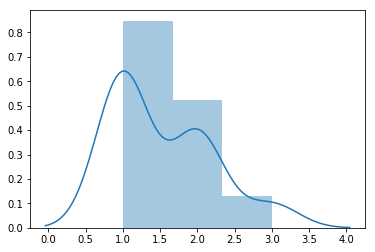

In [13]:
# get the distribution of entity path distances from the seed URI
dist_distr = [len(path[1]) for path in entities_paths]
print(dist_distr)

# plot entity path distance distribution
%matplotlib inline
import seaborn as sns
import numpy as np

# supress warning message
import warnings
warnings.filterwarnings('ignore')

_ = sns.distplot(np.asarray(dist_distr), kde=True)


In [18]:
# get predicate labels
# following https://janakiev.com/blog/wikidata-mayors/
WD_SERVICE = 'https://query.wikidata.org/sparql'

LABEL_QUERY_TEMPLATE = '''
                        SELECT  *
                        WHERE {
                                wd:%s rdfs:label ?label .
                                FILTER ( langMatches( lang(?label), "EN" ) )
                              } 
                        LIMIT 1
                        '''

def get_WD_label(wd_id):
    '''Lookup Wikidata for predicate label'''
#     print wd_id
    r = requests.get(WD_SERVICE, params = {'format': 'json', 'query': LABEL_QUERY_TEMPLATE%wd_id})
    return r.json()['results']['bindings'][0]['label']['value']

# get path labels
for i, (entity_URI, entity_path) in enumerate(entities_paths): 
    # relation
    print(seed_label, get_WD_label(entity_URI))
    
    # distance
    print("%d hop"%dist_distr[i])
    
    # show labels on the whole path
    labeled_path = [get_WD_label(uri) for hop in entity_path for uri in hop]
    print(labeled_path)
    
    predicates = [get_WD_label(hop[1]) for hop in entity_path]
    print(predicates[0])
    print('\n')

('Pieter_Bruegel_the_Elder', u'Karel van Mander I')
2 hop
[u'Pieter Brueghel the Elder', u'described by source', u'Schilder-boeck', u'Schilder-boeck', u'author', u'Karel van Mander I']
described by source


('Pieter_Bruegel_the_Elder', u'Schilder-boeck')
1 hop
[u'Pieter Brueghel the Elder', u'described by source', u'Schilder-boeck']
described by source


('Pieter_Bruegel_the_Elder', u'Breda')
1 hop
[u'Pieter Brueghel the Elder', u'place of birth', u'Breda']
place of birth


('Pieter_Bruegel_the_Elder', u'Pieter Coecke van Aelst')
1 hop
[u'Pieter Brueghel the Elder', u'relative', u'Pieter Coecke van Aelst']
relative


('Pieter_Bruegel_the_Elder', u'Mayken Coecke')
1 hop
[u'Pieter Brueghel the Elder', u'spouse', u'Mayken Coecke']
spouse


('Pieter_Bruegel_the_Elder', u'Mayken Verhulst')
2 hop
[u'Pieter Brueghel the Elder', u'relative', u'Pauwels Coecke van Aelst', u'Pauwels Coecke van Aelst', u'mother', u'Mayken Verhulst']
relative


('Pieter_Bruegel_the_Elder', u'Guild of Saint Luke')
2